# Post Calibration
1. Assess Results
    - Recalculate results for training set using best coefficients
    - Use best coefficients to calculate objective function for the test set
    - Compare against the shortest path results (with and without the elevation correction) using both training and testing sets
1. Look at where calibrated function did the best/worst job for both the training/testing set
1. Cluster/segment results based on loss function value?
4. Export for application in BikewaySim

In [1]:
from pathlib import Path
import time
import pandas as pd
import geopandas as gpd
import numpy as np
import pickle
import networkx as nx
from stochopy.optimize import minimize
import stochastic_optimization
from tqdm import tqdm
import similaritymeasures
import random
import matplotlib.pyplot as plt

from shapely.ops import LineString, MultiLineString

import sys
sys.path.insert(0,str(Path.cwd().parent))
from network.src import modeling_turns
import speedfactor

In [2]:
import json
config = json.load((Path.cwd().parent / 'config.json').open('rb'))
calibration_fp = Path(config['project_directory']) / 'Calibration'
cycleatl_fp = Path(config['project_directory']) / 'CycleAtlanta'
matching_fp = Path(config['project_directory']) / 'Map_Matching'
network_fp = Path(config['project_directory']) / 'Network'
if calibration_fp.exists() == False:
    calibration_fp.mkdir()

# Import Calibration Results and Calibration Network

In [3]:
with (calibration_fp/"calibration_network.pkl").open('rb') as fh:
    links,turns = pickle.load(fh)
with (calibration_fp/"calibration_results.pkl").open('rb') as fh:
    calibration_results = pickle.load(fh)
turn_G = modeling_turns.make_turn_graph(turns)

In [4]:
#dicts for referencing certain link attributes quickly
length_dict = dict(zip(links['linkid'],links['length_ft'])) # need this for loss function
geo_dict = dict(zip(links['linkid'],links['geometry']))

In [5]:
with (calibration_fp/'test_set.pkl').open('rb') as fh:
    test_set = pickle.load(fh)
with (calibration_fp/'train_set.pkl').open('rb') as fh:
    train_set = pickle.load(fh)

# import random
# random_trip = 1797#random.choice(list(train_set.keys()))
# train_set = {random_trip:train_set[random_trip]}

#match the ods to the network
train_ods = stochastic_optimization.match_results_to_ods(train_set)
test_ods = stochastic_optimization.match_results_to_ods(test_set)

In [6]:

'''
Currently works with binary and numeric variables. Categorical data will have to be
cast into a different format for now.

Link impedance is weighted by the length of the link, turns are just the impedance associated
'''

#customize this function to change impedance formula
#TODO streamline process of trying out new impedance functions
def link_impedance_function(betas,beta_links,links,base_impedance_col):
    #prevent mutating the original links gdf
    links = links.copy()
    
    multiplier = np.zeros(links.shape[0])
    
    if len(beta_links) > 0:
        #assumes that these effects are additive
        #TODO i think this can be done as a matrix product
        for key, item in beta_links.items():
            multiplier = multiplier + (betas[key] * links[item].values)
    
        links['link_cost'] = links[base_impedance_col] * (1 + multiplier) #removeing the + 1 for now

    else:
        links['link_cost'] = links[base_impedance_col]

    return links

def turn_impedance_function(betas,beta_turns,turns):
    #use beta coefficient to calculate turn cost
    # base_turn_cost = 30 # from Lowry et al 2016 DOI: http://dx.doi.org/10.1016/j.tra.2016.02.003
    # turn_costs = {
    #     'left': betas[1] * base_turn_cost,
    #     'right': betas[1] * base_turn_cost,
    #     'straight': betas[1] * base_turn_cost
    # }
    #turns['turn_cost'] = turns['turn_type'].map(turn_costs)

    turns = turns.copy()
    turns['turn_cost'] = 0

    if len(beta_turns) > 0:
        #instance impedance
        for key, item in beta_turns.items():
            turns['turn_cost'] = turns['turn_cost'] + (betas[key] * turns[item])

    #not sure if needed
    turns['turn_cost'] = turns['turn_cost'].astype(float)

    return turns

# Shortest Path Comparison

In [7]:
loss_function = stochastic_optimization.jaccard_index
loss_function_kwargs = {'length_dict':length_dict}
base_impedance_col = "travel_time_min"

In [8]:
#shortest path results here for comparison
stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)
results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,start_node,end_node) for start_node, end_node in train_ods}
loss_shortest_train = loss_function(train_set,results_dict,**loss_function_kwargs)
print(loss_shortest_train.mean().round(5))
# 0.29911

0.29911


In [9]:
stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)
results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,start_node,end_node) for start_node, end_node in test_ods}
loss_shortest_test = loss_function(test_set,results_dict,**loss_function_kwargs)
print(loss_shortest_test.mean().round(5))
# 0.3053

0.3053


(array([161.,  92.,  53.,  41.,  43.,  21.,  18.,  20.,  20.,  31.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

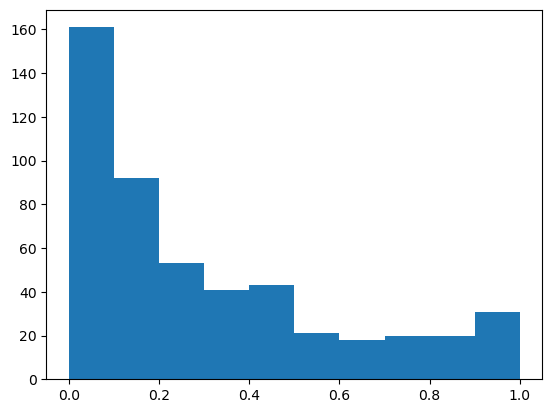

In [10]:
plt.hist(loss_shortest_test)

In [11]:
# #shortest path results here for comparison
# stochastic_optimization.back_to_base_impedance("adj_travel_time_min",links,turns,turn_G)
# results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,start_node,end_node) for start_node, end_node in train_ods}
# loss_values = loss_function(train_set,results_dict,**loss_function_kwargs)
# print(loss_values.mean().round(5))
# # 0.31022

In [12]:
# stochastic_optimization.back_to_base_impedance("adj_travel_time_min",links,turns,turn_G)
# results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,start_node,end_node) for start_node, end_node in test_ods}
# loss_values = loss_function(test_set,results_dict,**loss_function_kwargs)
# print(loss_values.mean().round(5))
# # 0.30337

# Generate Shortest Paths from Calibrated Coefficients

In [13]:
calibration_results

[{'high_traffic_stress': 0.0661610119497198,
  'left': 2.363333949708205,
  'right': 2.875007430851495,
  'signalized': 1.0893697547325298,
  'loss': -0.31058206517829084},
 {'class_1': 0.2308230358521835,
  'class_2': 1.2595525736224469,
  'class_3': 1.6777012261955218,
  'high_traffic_stress': 1.3901822221263547,
  'loss': -0.058962721570665844},
 {'major_road_w_class_2': 0.009352298764821576,
  'minor_road_w_class_2': 0.7192848670201979,
  'major_road_no_facil': 1.0242846535338108,
  'minor_road_no_facil': 1.4280555289480468,
  'above_4': 1.5152250035581623,
  'unsig_major_road_crossing': 0.012773275662048,
  'loss': -0.2903367458779148,
  'beta_links': {0: 'major_road_w_class_2',
   1: 'minor_road_w_class_2',
   2: 'major_road_no_facil',
   3: 'minor_road_no_facil',
   4: 'above_4'},
  'beta_turns': {5: 'unsig_major_road_crossing'}},
 {'mixed_traffic_no_facil': 0.46263003513032264,
  'mixed_traffic_w_facil': 0.12362448102583937,
  'above_4': 1.5311721170426633,
  'unsig_major_road_

In [14]:
calibration_result = calibration_results[-1]
calibration_result


{'mixed_traffic_no_facil': 0.46263003513032264,
 'mixed_traffic_w_facil': 0.12362448102583937,
 'above_4': 1.5311721170426633,
 'unsig_major_road_crossing': 1.3426500745160708,
 'loss': -0.31513428304183927,
 'beta_links': {0: 'mixed_traffic_no_facil',
  1: 'mixed_traffic_w_facil',
  2: 'above_4'},
 'beta_turns': {3: 'unsig_major_road_crossing'}}

In [15]:
betas = list(calibration_result.values())[0:-3]
betas_links = calibration_result['beta_links']
betas_turns = calibration_result['beta_turns']
# betas_links = {
#     0 : 'major_road_w_class_2',
#     1 : 'minor_road_w_class_2',
#     2 : 'major_road_no_facil',
#     3 : 'minor_road_no_facil',
# }
# betas_turns = {
#     4 : 'unsig_major_road_crossing'
# }
betas

[0.46263003513032264,
 0.12362448102583937,
 1.5311721170426633,
 1.3426500745160708]

In [16]:
#link_impedance_col = "adj_travel_time_min"
base_impedance_col = "travel_time_min"
stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)

#update impedances
#betas = #past_betas[np.array(past_vals).argmin()]#x.x
print(betas)
stochastic_optimization.impedance_update(betas,betas_links,betas_turns,
                          link_impedance_function,
                          base_impedance_col,
                          turn_impedance_function,
                          links,turns,turn_G)

#find shortest path
results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,start_node,end_node) for start_node, end_node in train_ods}

#calulate objective function
loss_train = loss_function(train_set,results_dict,**loss_function_kwargs)
loss_train.mean()

[0.46263003513032264, 0.12362448102583937, 1.5311721170426633, 1.3426500745160708]


0.31513428304183927

In [17]:
loss_shortest_train

array([4.26217290e-02, 5.03563514e-01, 3.99908704e-01, 1.88000121e-02,
       6.90454006e-01, 7.21419782e-02, 1.40919168e-01, 1.65826970e-01,
       1.00000000e+00, 7.46157317e-01, 8.40440100e-02, 2.09710978e-01,
       0.00000000e+00, 3.58259018e-01, 5.71818931e-02, 7.08699291e-03,
       2.27937657e-01, 1.46945137e-01, 4.80763695e-02, 1.20489160e-01,
       1.68555558e-01, 1.48409347e-01, 1.27419912e-01, 7.54722480e-01,
       5.03251434e-01, 8.64934134e-01, 2.79386359e-01, 2.58005877e-01,
       1.28435633e-01, 5.76391499e-02, 0.00000000e+00, 8.60381412e-01,
       1.16910499e-01, 1.47436558e-01, 7.03756191e-01, 3.43617459e-01,
       5.82283421e-01, 3.77839830e-02, 3.41193841e-01, 6.55460352e-02,
       2.56423069e-02, 1.96353798e-01, 8.54630815e-02, 2.38359169e-02,
       1.72011507e-01, 9.91378673e-02, 1.88612490e-02, 7.09152672e-02,
       1.64302996e-02, 1.12751276e-01, 2.46129004e-01, 2.03125388e-01,
       3.80230281e-01, 1.30706093e-01, 1.99352550e-01, 2.38437911e-01,
      

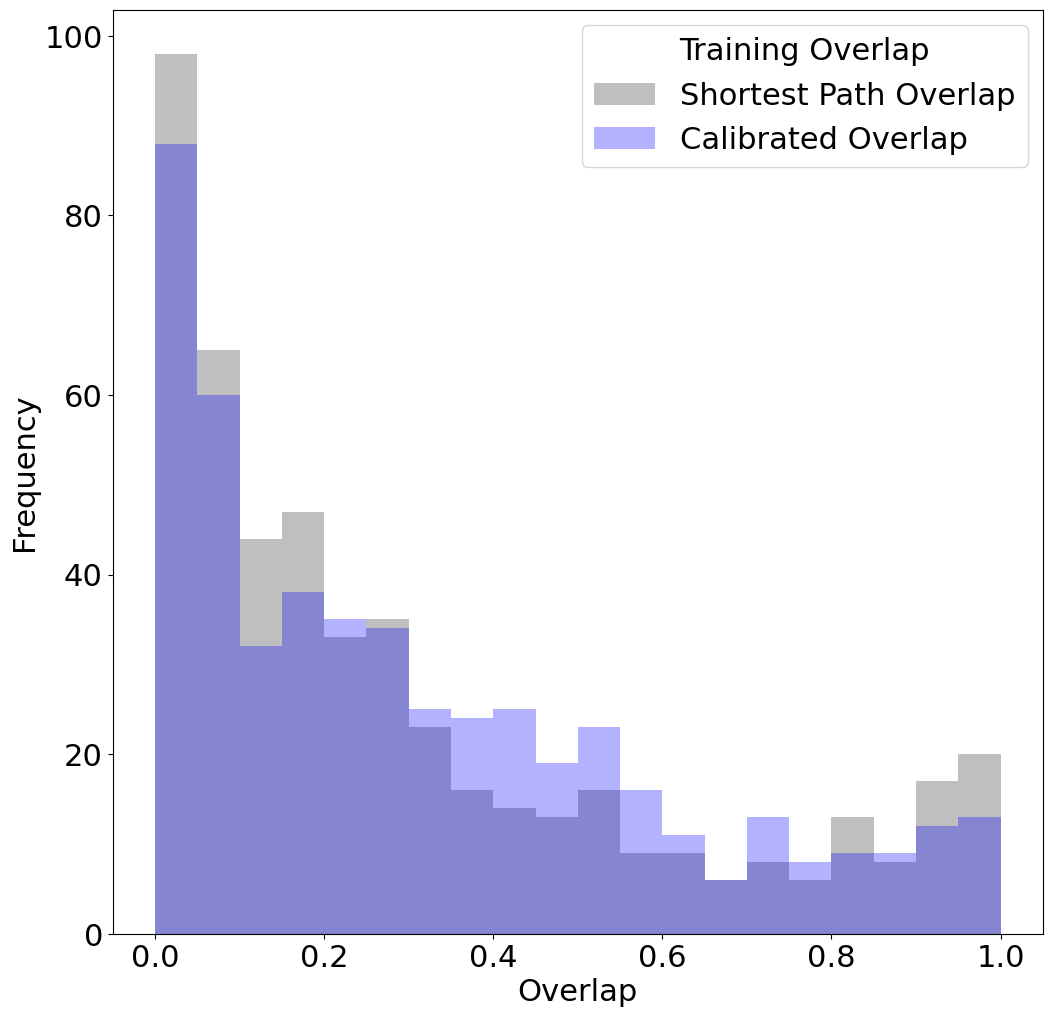

In [33]:
import pandas as pd
loss_data = pd.DataFrame({'loss_shortest_train':loss_shortest_train,'loss_train':loss_train})

import matplotlib.pyplot as plt
# Create the histogram
#ax = loss_train_df.plot.hist(stacked=True, bins=20, figsize=(12, 12), color=['grey', 'lightgrey'])

# Create the histogram
plt.figure(figsize=(12, 12))
plt.hist(loss_data['loss_shortest_train'], bins=20, alpha=0.5, label='Shortest Path Overlap', color='grey')
plt.hist(loss_data['loss_train'], bins=20, alpha=0.3, label='Calibrated Overlap', color='blue')

# Adding labels, title, and legend with font size adjustments
plt.xlabel('Overlap', fontsize=22)
plt.ylabel('Frequency', fontsize=22)
#plt.title('Histogram of Training Losses', fontsize=16)
plt.legend(title='Training Overlap', fontsize=22, title_fontsize=22)

# Adjusting the font size of the tick labels
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

# Show the plot
plt.show()

(array([148.,  70.,  69.,  49.,  44.,  39.,  17.,  21.,  18.,  25.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

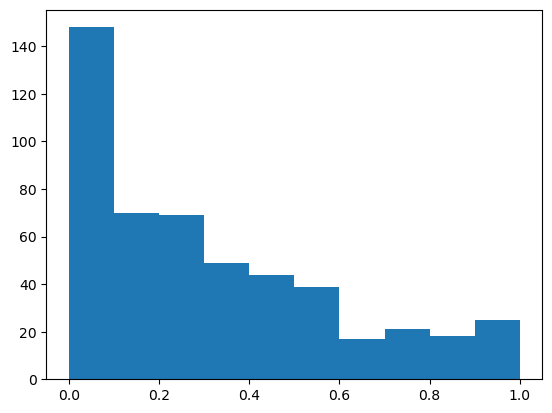

In [19]:
import matplotlib.pyplot as plt
plt.hist(loss_train)

In [20]:
#link_impedance_col = "adj_travel_time_min"
base_impedance_col = "travel_time_min"
stochastic_optimization.back_to_base_impedance(base_impedance_col,links,turns,turn_G)

#update impedances
#betas = #past_betas[np.array(past_vals).argmin()]#x.x
print(betas)
stochastic_optimization.impedance_update(betas,betas_links,betas_turns,
                          link_impedance_function,
                          base_impedance_col,
                          turn_impedance_function,
                          links,turns,turn_G)

#find shortest path
results_dict = {(start_node,end_node):stochastic_optimization.impedance_path(turns,turn_G,start_node,end_node) for start_node, end_node in test_ods}

#calulate objective function
loss_test = loss_function(test_set,results_dict,**loss_function_kwargs)
loss_test.mean()

[0.46263003513032264, 0.12362448102583937, 1.5311721170426633, 1.3426500745160708]


0.3317244178557114

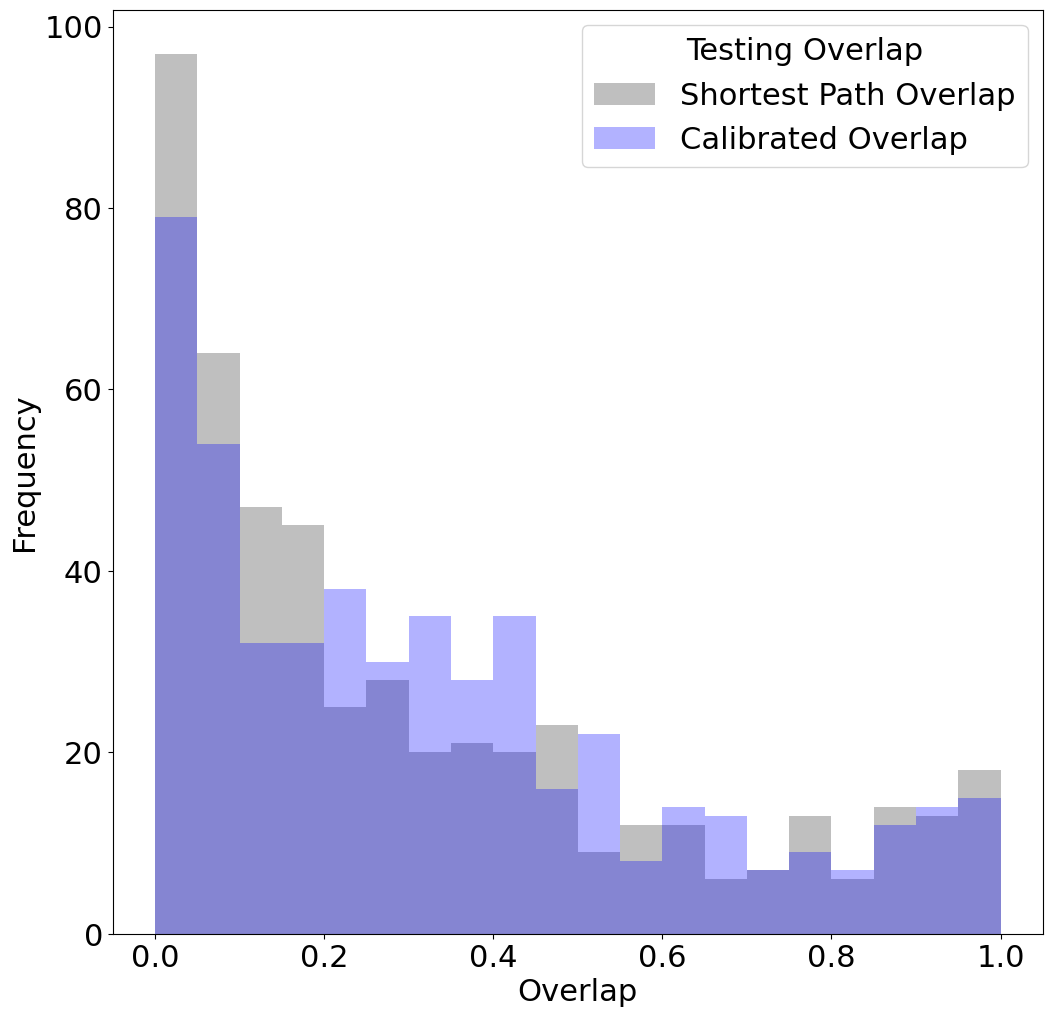

In [32]:
loss_data = pd.DataFrame({'loss_shortest_test':loss_shortest_test,'loss_test':loss_test})

import matplotlib.pyplot as plt
# Create the histogram
#ax = loss_train_df.plot.hist(stacked=True, bins=20, figsize=(12, 12), color=['grey', 'lightgrey'])

# Create the histogram
plt.figure(figsize=(12, 12))
plt.hist(loss_data['loss_shortest_test'], bins=20, alpha=0.5, label='Shortest Path Overlap', color='grey')
plt.hist(loss_data['loss_test'], bins=20, alpha=0.3, label='Calibrated Overlap', color='blue')

# Adding labels, title, and legend with font size adjustments
plt.xlabel('Overlap', fontsize=22)
plt.ylabel('Frequency', fontsize=22)
#plt.title('Histogram of Training Losses', fontsize=16)
plt.legend(title='Testing Overlap', fontsize=22, title_fontsize=22)

# Adjusting the font size of the tick labels
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

# Show the plot
plt.show()

In [ ]:
#make dataframe and export
testing = pd.DataFrame({'shortest':loss_shortest_test,'impedance':loss_test})
testing.to_csv(calibration_fp/'testing_results.csv',index=False)
training = pd.DataFrame({'shortest':loss_shortest_train,'impedance':loss_train})
training.to_csv(calibration_fp/'training_results.csv',index=False)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(loss_test)

# Distribution of Loss Function

# Export to get route attributes

# Using BRouter Results
To compare across we'll use Frechet distance. Will need to use next time.

In [ ]:
with (calibration_fp/'brouter_links.txt').open('r') as file:
    my_list = file.readlines()
    # Remove any extra whitespace or newline characters
    my_list = [line.strip() for line in my_list]
len(my_list)

In [ ]:
geojsons = list((calibration_fp/'GeoJSON_Out').glob('*.geojson'))

In [ ]:
both_ods = list(set.union(set(train_ods),set(test_ods)))
len(both_ods)

In [ ]:
len(geojsons)

In [ ]:
#use the results dict combined with the geo dict one
results_dict[(68166811, 8789832117)]
#

In [ ]:
geojson_geos = []
for geojson in geojsons:
    geojson_geo = gpd.read_file(geojson).to_crs(config['projected_crs_epsg'])
    geojson_geo = np.array(geojson_geo.geometry.item().coords)
    # geojson_geo = [(x, y) for x, y, z in geojson_geo.coords]
    # geojson_geo = LineString(geojson_geo)
    geojson_geos.append(geojson_geo)

In [ ]:
frechet_distance = similaritymeasures.frechet_dist(chosen_coords,modeled_coords)

In [ ]:
#import and compare frechet distance across them with geodict?
list(geojson_geo.coords)